### Blackjack - Basic Strategy

This file contains the implementation of Basic strategy of Blackjack with and with Q-learning agent along with Rule Variations.

#### BlackJack - Basic strategy without Q-Learning

All the Neccessary packages are imported

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import seaborn as sns
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
import matplotlib.colors as mcolors

Defines all the constants neccesary in the implementation for easy access of the data

In [2]:
# Define constants

# suits
SPADES = "spades"
HEARTS = "hearts"
DIAMONDS = "diamonds"
CLUBS = "clubs"
# values
TWO = "2"
THREE = "3"
FOUR = "4"
FIVE = "5"
SIX = "6"
SEVEN = "7"
EIGHT = "8"
NINE = "9"
TEN = "10"
JACK = "jack"
QUEEN = "queen"
KING = "king"
ACE = "ace"

# ace values
ACE_HIGH_VALUE = 11
ACE_LOW_VALUE = 1

# Rewards
DRAW_REWARD = 0
WIN_REWARD = 1
LOSE_REWARD = -1
DOUBLE_DOWN_WIN_REWARD = 2
DOUBLE_DOWN_LOSE_REWARD = -2
WIN_BLACKJACK_REWARD = 10
WIN_BLACKJACK_REWARD_6_TO_5 = 12
INVALID_ACTION_REWARD = -3
VALID_ACTION_REWARD = 3


# actions
HIT = "hit"
STAND = "stand"
DOUBLE_DOWN = "double_down"
SPLIT = "split"
ACTIONS = [HIT,STAND,DOUBLE_DOWN,SPLIT]
HARD_HAND = "hard"
SOFT_HAND = "soft"

# card counting categories
HIGH_CARDS = [TEN, JACK, QUEEN, KING, ACE]
LOW_CARDS = [TWO, THREE, FOUR, FIVE, SIX]
NEUTRAL_CARDS = [SEVEN, EIGHT, NINE]

This class `Blackjack (object)` defines the blackjack environment all the basic rules and actions

In [27]:
class Blackjack (object):
    def __init__ (self,random_seed=None) :
        if random_seed is not None:
            random.seed(random_seed)
        self.deck = self.create_deck()
        self.player_card = []
        self.dealer_card = []
        self.has_ace = False
        self.end_game = False
        self.reward = 0
        self.hand = HARD_HAND
        self.split_flag = False
        self.natural_flag = False
        self.newgame = self.reset()
    
    
    def create_deck(self) :
        suits = [SPADES,DIAMONDS,HEARTS,CLUBS]
        ranks = [TWO,THREE,FOUR,FIVE,SIX,SEVEN,EIGHT,NINE,TEN,JACK,QUEEN,KING,ACE]
        deck = list(itertools.product(ranks,suits))
        random.shuffle(deck)
        return deck
        
    def get_card(self) :
        top_card = self.deck.pop()
        if(len(top_card) == 0) :
            top_card = self.create_deck().pop()
        return top_card
        
    def calculate_card_value(self,dealer_card,cards):
        value = 0
        number_aces = 0 
        self.hand = HARD_HAND
        for card , suit in cards :
            if str(card).lower() in [JACK,QUEEN,KING] :
                 value+=10
            elif str(card).isnumeric() :
                value+=int(card)
            elif str(card).lower() in [ACE] : 
                number_aces +=1 
        if dealer_card :
            for i in range (number_aces):
                if (value + 11 ) > 21 :
                    value += ACE_LOW_VALUE
                else :
                    value+= ACE_HIGH_VALUE
        else :
            for i in range (number_aces):
                if (value + 11 ) > 21 :
                    value += ACE_LOW_VALUE
                    self.hand = HARD_HAND
                else :
                    value+= ACE_HIGH_VALUE
                    self.hand = SOFT_HAND
            
        
        return value
    
    def reset(self) :
        #Re-initialisation for starting new game or episode 
        self.deck = self.create_deck()
        self.player_card = [self.get_card(), self.get_card()]
        self.dealer_card = [self.get_card(), self.get_card()]
        self.hand = HARD_HAND
        self.has_ace = self.contains_ace(self.player_card)
        self.end_game = False
        self.split_flag = True if (len(self.player_card) == 2 and self.player_card[0][0] == self.player_card[1][0]) else False
        self.natural_flag = True if (len(self.player_card) == 2 and self.calculate_card_value(False,self.player_card) == 21) else False
        return self.state_status()

    def state_status(self):
        player_card_value = self.calculate_card_value(False,self.player_card)
        dealer_first_card = self.dealer_card[0][0]
        self.split_flag = True if (len(self.player_card) == 2 and self.player_card[0][0] == self.player_card[1][0]) else False
        self.natural_flag = True if (len(self.player_card) == 2 and self.calculate_card_value(False,self.player_card) == 21) else False
        return player_card_value,dealer_first_card,self.has_ace,self.hand,self.split_flag,self.natural_flag
    
    def contains_ace(self,player_card) : 
        for card , suit in player_card :
            if card.casefold() == ACE.casefold() :
                return True
        return False


    def step(self,rule_no_dd_hard_11,rule_6_to_5) :
        player_card_numbers = []
        dealer_card_numbers = []
        for p_card in self.player_card :
            player_card_numbers.append(p_card[0]) 
            
        for d_card in self.dealer_card :
            dealer_card_numbers.append(d_card[0]) 
            
        if len(player_card_numbers) == 2 and len(dealer_card_numbers) == 2 :
            state_status, self.reward, end_game = self.check_for_blackjack(rule_6_to_5)
            if end_game :
                return state_status,self.reward, end_game
            
            split_flag = self.choose_splitting_pairs(player_card_numbers,dealer_card_numbers[0])
            double_down_flag = self.choose_double_down(player_card_numbers,dealer_card_numbers[0],self.calculate_card_value(False,self.player_card),rule_no_dd_hard_11)

            if split_flag :
                self.split_pairs(dealer_card_numbers[0],rule_no_dd_hard_11)
            elif double_down_flag :
                action,double_down_action = self.double_down(self.player_card)
                self.general_rule(action,double_down_action)
            else :
                action = self.hit_or_stand(dealer_card_numbers[0],self.calculate_card_value(False,self.player_card))
                self.general_rule(action,None)
        else :
            action = self.hit_or_stand(dealer_card_numbers[0],self.calculate_card_value(False,self.player_card))
            self.general_rule(action,None)

        return self.state_status(),self.reward,self.end_game 
        
    def general_rule(self,action,double_down_action) :
        # Hit / Stand
        if action.lower() == HIT :
            self.player_card.append(self.get_card())
            player_card_value = self.calculate_card_value(False,self.player_card)
            if(player_card_value > 21) :
                #print("Player Lost / busted ")
                self.end_game = True
                self.reward = LOSE_REWARD
                return self.state_status(),self.reward,self.end_game
            else : 
                self.reward = 0
        elif action.lower() == STAND :
            #End of players turn, begin dealers turn
            self.end_game = True
            dealer_card_value = self.calculate_card_value(True,self.dealer_card)
            while (dealer_card_value < 17 ) :
                self.dealer_card.append(self.get_card())
                dealer_card_value = self.calculate_card_value(True,self.dealer_card)
            
            self.reward = self.winner_or_loser(double_down_action)     
        return self.state_status(),self.reward,self.end_game 
    
    
    def winner_or_loser(self,double_down_action) : 
        player_card_value = self.calculate_card_value(False,self.player_card)
        dealer_card_value = self.calculate_card_value(True,self.dealer_card)
        if double_down_action == DOUBLE_DOWN :
            if player_card_value  > 21 :
                return DOUBLE_DOWN_LOSE_REWARD #player busted
            elif dealer_card_value > 21 :
                return DOUBLE_DOWN_WIN_REWARD #Player wins dealer busted
            elif player_card_value > dealer_card_value :
                return DOUBLE_DOWN_WIN_REWARD # Player wins
            elif player_card_value < dealer_card_value : 
                return DOUBLE_DOWN_LOSE_REWARD #Player lost dealer won
            else : 
                return DRAW_REWARD #its draw
        else :
            if player_card_value  > 21 :
                return LOSE_REWARD #player busted
            elif dealer_card_value > 21 :
                return WIN_REWARD #Player wins dealer busted
            elif player_card_value > dealer_card_value :
                return WIN_REWARD # Player wins
            elif player_card_value < dealer_card_value : 
                return LOSE_REWARD #Player lost dealer won
            else : 
                return DRAW_REWARD #its draw
        
    def check_for_blackjack(self,rule_6_to_5) :
        player_card_numbers = []
        dealer_card_numbers = []
        for p_card in self.player_card :
            player_card_numbers.append(p_card[0]) 
            
        for d_card in self.dealer_card :
            dealer_card_numbers.append(d_card[0]) 
            
        self.end_game = False
        if len(player_card_numbers) == 2 and len(dealer_card_numbers) == 2 :
            player_card_value = self.calculate_card_value(False,self.player_card)
            dealer_card_value = self.calculate_card_value(True,self.dealer_card)
            if player_card_value  == 21 and dealer_card_value == 21:
                self.end_game = True
                self.reward = DRAW_REWARD
            if player_card_value == 21 :
                self.end_game = True
                if rule_6_to_5 :
                    self.reward = WIN_BLACKJACK_REWARD_6_TO_5  #Rule variation Apply 6 to 5 rule for blackjack instead of 3 to 2
                else :
                    self.reward = WIN_BLACKJACK_REWARD
            
        return self.state_status(),self.reward,self.end_game         
    
    #when same numbers occur twice split
    def choose_splitting_pairs(self,player_card_numbers,dealer_face_up_card):
        split = False
        if len(player_card_numbers) == 2:
            if player_card_numbers[0] == player_card_numbers [1] :
                #always split
                if player_card_numbers[0] in [ACE,EIGHT] :
                    split = True
                
                #never split
                if player_card_numbers[0] in [FIVE,TEN,JACK,QUEEN,KING]:
                    split = False
                
                #split based on dealer up card
                #if dealer face up card is b/w 2-7 and player has 2s or 3s or 7s
                if (dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX,SEVEN] and player_card_numbers[0] in TWO) or (dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX,SEVEN] and player_card_numbers[0] in THREE) or (dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX,SEVEN] and player_card_numbers[0] in SEVEN):
                    split = True
                
                #if dealer face up card is b/w 5-6 and player has 4s
                if dealer_face_up_card in [FIVE,SIX] and player_card_numbers[0] in FOUR :
                    split = True
                
                #if dealer face up card is b/w 2-6 and player has 6s
                if dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX] and player_card_numbers[0] in SIX :
                    split = True
                
                #if dealer face up card is b/w 2-6 and player has 6s
                if dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX,EIGHT,NINE] and player_card_numbers[0] in NINE :
                    split = True
            
        return split
    
    #conditions for double down
    def choose_double_down(self,player_card_numbers,dealer_face_up_card,player_card_value,rule_no_dd_hard_11) :
        double_down = False
       
        if len(player_card_numbers) == 2 :
            #if hard hand
            if self.hand == HARD_HAND :
                #gets 11 always double down
                if player_card_value == 11 :
                    if rule_no_dd_hard_11 :
                        double_down = False  #Rule variation do not double down when hard 11
                    else :
                        double_down = True
                #if dealer face up card is b/w 2-9 and player has hard 10
                if dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX,SEVEN,EIGHT,NINE] and player_card_value == 10 :
                    double_down = True
                #if dealer face up card is b/w 3-6 and player has hard 9
                if dealer_face_up_card in [THREE,FOUR,FIVE,SIX] and player_card_value == 8 :
                    double_down = True
            
            if self.hand == SOFT_HAND :
                #if dealer face up card is b/w 3-6 and player has soft 13 - 18
                if player_card_value in range (13,19) and dealer_face_up_card in [THREE,FOUR,FIVE,SIX]:
                    double_down = True
                #if dealer face up card is b/w 6 and player has soft 19
                if player_card_value == 19 and dealer_face_up_card in [SIX]:
                    double_down = True
                
        return double_down
                       
    def hit_or_stand(self,dealer_face_up_card,player_card_value) :
        action = ''
        if self.hand == HARD_HAND :
            #if player has hard <=8
            if player_card_value <= 11 :
                action = HIT
                
            #if dealer face up card is 2-3 or 7-A and player has hard 12 else stand
            if player_card_value == 12 :
                if dealer_face_up_card in [TWO,THREE,SEVEN,EIGHT,NINE,TEN,JACK,QUEEN,KING,ACE] :
                    action = HIT
                else : 
                    action = STAND 
        
            #if dealer face up card is 7-A and player has hard 13-16 else stand
            if player_card_value in range (13,17) :
                if dealer_face_up_card in [SEVEN,EIGHT,NINE,TEN,JACK,QUEEN,KING,ACE] :
                    action = HIT
                else : 
                    action = STAND
                
            #if  player has hard >= 17 else stand
            if player_card_value >= 17 :
                action = STAND
        
        if self.hand == SOFT_HAND :
            
            #if dealer face up card is 2-4 or 7-A and player has soft 13-14
            if player_card_value <= 17 :
                action = HIT

            #if dealer face up card is 9-A and player has soft 18 else stand dealers face up card is 2 or 7,8
            if player_card_value == 18 :
                if dealer_face_up_card in [NINE,TEN,JACK,QUEEN,KING,ACE] :
                    action = HIT
                elif dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX,SEVEN,EIGHT] : 
                    action = STAND
                
            #if dealer face up card is not 6 and player has soft 19
            if player_card_value >= 19 :
                action = STAND
        
        return action
    
    def split_pairs(self,dealer_face_up_card,rule_no_dd_hard_11):
        rewards = []
        player_new_card_1 = self.get_card()
        player_new_card_2 = self.get_card()
        player_hand_1 = [self.player_card[0], player_new_card_1]
        player_hand_2 = [self.player_card[1], player_new_card_2]
        player_hands = [player_hand_1, player_hand_2]
        self.player_card.append(player_new_card_1)
        self.player_card.append(player_new_card_2)
       
        for hand in player_hands:
            hand_card_numbers = []
            self.player_card = hand  # Set current hand to be played
            self.has_ace = self.contains_ace(hand)
            
            for p_card in hand :
                hand_card_numbers.append(p_card[0]) 
            
            double_down_flag = self.choose_double_down(hand_card_numbers,dealer_face_up_card,self.calculate_card_value(False,hand),rule_no_dd_hard_11)
            if double_down_flag :
                action,double_down_action = self.double_down(hand)
                state_status,self.reward,self.end_game = self.general_rule(action,double_down_action)
                rewards.append(self.reward)
            else : 
                action = self.hit_or_stand(dealer_face_up_card,self.calculate_card_value(False,hand))
                state_status,self.reward,self.end_game = self.general_rule(action,None)
                rewards.append(self.reward)
        
        # Determine final rewards based on the outcome of both hands
        if all(reward > 0 for reward in rewards):
            # Both hands win
            self.reward = sum(rewards)  # Add rewards for both winning hands
        elif all(reward < 0 for reward in rewards):
            # Both hands lose
            self.reward = sum(rewards)  # Sum of negative rewards is negative
        else:
            # One hand wins and one hand loses
            self.reward = sum(rewards)  # Net reward
        
        self.reward+=VALID_ACTION_REWARD
        return self.state_status(),self.reward,self.end_game 
        
    def double_down(self,hand) :
        hand.append(self.get_card())
        self.end_game = True
        action = STAND
        return action,DOUBLE_DOWN

Testing

In [34]:
def test_blackjack_bs(num_episodes,rule_no_dd_hard_11,rule_6_to_5):
    env = Blackjack()
    wins = 0
    losses = 0
    draws = 0
    pos_rewards = []
    neg_rewards = []
    neu_rewards = []
    average_reward = 0.0
    for _ in range(num_episodes):
        env.reset()
        done = False

        while not done:
            _, reward, done = env.step(rule_no_dd_hard_11,rule_6_to_5)
       
        if reward in [WIN_REWARD, WIN_BLACKJACK_REWARD, DOUBLE_DOWN_WIN_REWARD]:
            pos_rewards.append(reward)
            wins += 1
        elif reward in [LOSE_REWARD ,DOUBLE_DOWN_LOSE_REWARD]:
            neg_rewards.append(reward)
            losses += 1
        else:
            neu_rewards.append(reward)
            draws += 1
        
    win_rate = wins / num_episodes * 100
    loss_rate = losses / num_episodes * 100
    draw_rate = draws / num_episodes * 100
   
    
    print(f"Average  win reward : {sum(pos_rewards)/wins:.2f} , average loss reward : {sum(neg_rewards)/losses:.2f} , average draw reward: {sum(neu_rewards)/draws:.2f}")
    print(f"Wins: {wins} , win percentage: {win_rate:.2f}%")
    print(f"Losses: {losses} , loss percentage: {loss_rate:.2f}%")
    print(f"Draws: {draws} , draw percentage: {draw_rate:.2f}%")



In [35]:
test_blackjack_bs(100000,False,False)

Average  win reward : 2.14 , average loss reward : -1.09 , average draw reward: 0.50
Wins: 43633 , win percentage: 43.63%
Losses: 46823 , loss percentage: 46.82%
Draws: 9544 , draw percentage: 9.54%


#### BlackJack - Basic strategy with Q-Learning

In [5]:
class Blackjack_Q (object):
    def __init__ (self) :
        self.deck = self.create_deck()
        self.player_card = []
        self.dealer_card = []
        self.has_ace = False
        self.end_game = False
        self.reward = 0
        self.hand = HARD_HAND
        self.split_flag = False
        self.natural_flag = False
        self.newgame = self.reset()
    
    
    def create_deck(self) :
        suits = [SPADES,DIAMONDS,HEARTS,CLUBS]
        ranks = [TWO,THREE,FOUR,FIVE,SIX,SEVEN,EIGHT,NINE,TEN,JACK,QUEEN,KING,ACE]
        deck = list(itertools.product(ranks,suits))
        random.shuffle(deck)
        return deck
        
    def get_card(self) :
        top_card = self.deck.pop()
        if(len(top_card) == 0) :
            top_card = self.create_deck().pop()
        return top_card
        
    def calculate_card_value(self,dealer_card,cards):
        value = 0
        number_aces = 0 
        self.hand = HARD_HAND
        for card , suit in cards :
            if str(card).lower() in [JACK,QUEEN,KING] :
                 value+=10
            elif str(card).isnumeric() :
                value+=int(card)
            elif str(card).lower() in [ACE] : 
                number_aces +=1 
        if dealer_card :
            for i in range (number_aces):
                if (value + 11 ) > 21 :
                    value += ACE_LOW_VALUE
                else :
                    value+= ACE_HIGH_VALUE
        else :
            for i in range (number_aces):
                if (value + 11 ) > 21 :
                    value += ACE_LOW_VALUE
                    self.hand = HARD_HAND
                else :
                    value+= ACE_HIGH_VALUE
                    self.hand = SOFT_HAND
            
        
        return value
    
    def reset(self) :
        #Re-initialisation for starting new game or episode 
        self.deck = self.create_deck()
        self.player_card = [self.get_card(), self.get_card()]
        self.dealer_card = [self.get_card(), self.get_card()]
        self.hand = HARD_HAND
        self.has_ace = self.contains_ace(self.player_card)
        self.end_game = False
        self.split_flag = True if (len(self.player_card) == 2 and self.player_card[0][0] == self.player_card[1][0]) else False
        self.natural_flag = True if (len(self.player_card) == 2 and self.calculate_card_value(False,self.player_card) == 21) else False
        return self.state_status()

    def state_status(self):
        player_card_value = self.calculate_card_value(False,self.player_card)
        dealer_first_card = self.dealer_card[0][0]
        self.split_flag = True if (len(self.player_card) == 2 and self.player_card[0][0] == self.player_card[1][0]) else False
        self.natural_flag = True if (len(self.player_card) == 2 and self.calculate_card_value(False,self.player_card) == 21) else False
        return player_card_value,dealer_first_card,self.has_ace,self.hand,self.split_flag,self.natural_flag
    
    def contains_ace(self,player_card) : 
        for card , suit in player_card :
            if card.casefold() == ACE.casefold() :
                return True
        return False

    def step(self,q_action,rule_6_to_5,rule_no_dd_hard_11) :
        player_card_numbers = []
        dealer_card_numbers = []
        for p_card in self.player_card :
            player_card_numbers.append(p_card[0]) 
            
        for d_card in self.dealer_card :
            dealer_card_numbers.append(d_card[0]) 
            
        if q_action == SPLIT :
            if self.split_flag :
                self.split_pairs(dealer_card_numbers[0],rule_no_dd_hard_11,rule_6_to_5)
            else:
                self.reward = INVALID_ACTION_REWARD
                self.end_game = True
            return self.state_status(), self.reward, self.end_game
    
        elif q_action == DOUBLE_DOWN :
            action,double_down_action = self.double_down(self.player_card)
            self.reward+=VALID_ACTION_REWARD
            self.general_rule(action,double_down_action,rule_6_to_5)

        elif q_action == HIT:
            action = self.hit_or_stand(dealer_card_numbers[0], self.calculate_card_value(False, self.player_card))
            if q_action == action :
                self.reward += VALID_ACTION_REWARD
                self.general_rule(action, None,rule_6_to_5)
            else:
                self.reward = INVALID_ACTION_REWARD
                self.end_game = True
                return self.state_status(), self.reward, self.end_game
            
        elif q_action == STAND:
            action = self.hit_or_stand(dealer_card_numbers[0], self.calculate_card_value(False, self.player_card))
            if q_action == action :
                self.reward += VALID_ACTION_REWARD
                self.general_rule(action, None,rule_6_to_5)
            else:
                self.reward = INVALID_ACTION_REWARD
                self.end_game = True
                return self.state_status(), self.reward, self.end_game
            
        return self.state_status(),self.reward,self.end_game
        
    def general_rule(self,action,double_down_action,rule_6_to_5) :
        state_status, self.reward, end_game = self.check_for_blackjack(rule_6_to_5)
        if end_game :
            return state_status,self.reward, end_game
        # Hit / Stand
        if action.lower() == HIT :
            self.player_card.append(self.get_card())
            player_card_value = self.calculate_card_value(False,self.player_card)
            if(player_card_value > 21) :
                self.end_game = True
                self.reward = LOSE_REWARD
                return self.state_status(),self.reward,self.end_game
            else : 
                self.reward = 0
        elif action.lower() == STAND :
            #End of players turn, begin dealers turn
            self.end_game = True
            dealer_card_value = self.calculate_card_value(True,self.dealer_card)
            while (dealer_card_value < 17 ) :
                self.dealer_card.append(self.get_card())
                dealer_card_value = self.calculate_card_value(True,self.dealer_card)
            
            self.reward = self.winner_or_loser(double_down_action)     
        return self.state_status(),self.reward,self.end_game 
    
    
    def winner_or_loser(self,double_down_action) : 
        player_card_value = self.calculate_card_value(False,self.player_card)
        dealer_card_value = self.calculate_card_value(True,self.dealer_card)
        if double_down_action == DOUBLE_DOWN :
            if player_card_value  > 21 :
                return DOUBLE_DOWN_LOSE_REWARD #player busted
            elif dealer_card_value > 21 :
                return DOUBLE_DOWN_WIN_REWARD #Player wins dealer busted
            elif player_card_value > dealer_card_value :
                return DOUBLE_DOWN_WIN_REWARD # Player wins
            elif player_card_value < dealer_card_value : 
                return DOUBLE_DOWN_LOSE_REWARD #Player lost dealer won
            else : 
                return DRAW_REWARD #its draw
        else :
            if player_card_value  > 21 :
                return LOSE_REWARD #player busted
            elif dealer_card_value > 21 :
                return WIN_REWARD #Player wins dealer busted
            elif player_card_value > dealer_card_value :
                return WIN_REWARD # Player wins
            elif player_card_value < dealer_card_value : 
                return LOSE_REWARD #Player lost dealer won
            else : 
                return DRAW_REWARD #its draw
        
    def check_for_blackjack(self,rule_6_to_5) :
        player_card_numbers = []
        dealer_card_numbers = []
        for p_card in self.player_card :
            player_card_numbers.append(p_card[0]) 
            
        for d_card in self.dealer_card :
            dealer_card_numbers.append(d_card[0]) 
            
        self.end_game = False
        if len(player_card_numbers) == 2 and len(dealer_card_numbers) == 2 :
            player_card_value = self.calculate_card_value(False,self.player_card)
            dealer_card_value = self.calculate_card_value(True,self.dealer_card)
            if player_card_value  == 21 and dealer_card_value == 21:
                self.end_game = True
                self.reward = DRAW_REWARD
            if player_card_value == 21 :
                self.end_game = True
                if rule_6_to_5 :
                    self.reward = WIN_BLACKJACK_REWARD_6_TO_5  #Rule variation Apply 6 to 5 rule for blackjack instead of 3 to 2
                else :
                    self.reward = WIN_BLACKJACK_REWARD
            
        return self.state_status(),self.reward,self.end_game         
    
    #when same numbers occur twice split
    def choose_splitting_pairs(self,player_card_numbers,dealer_face_up_card):
        split = False
        if len(player_card_numbers) == 2:
            if player_card_numbers[0] == player_card_numbers [1] :
                #always split
                if player_card_numbers[0] in [ACE,EIGHT] :
                    split = True
                
                #never split
                if player_card_numbers[0] in [FIVE,TEN,JACK,QUEEN,KING]:
                    split = False
                
                #split based on dealer up card
                #if dealer face up card is b/w 2-7 and player has 2s or 3s or 7s
                if (dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX,SEVEN] and player_card_numbers[0] in TWO) or (dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX,SEVEN] and player_card_numbers[0] in THREE) or (dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX,SEVEN] and player_card_numbers[0] in SEVEN):
                    split = True
                
                #if dealer face up card is b/w 5-6 and player has 4s
                if dealer_face_up_card in [FIVE,SIX] and player_card_numbers[0] in FOUR :
                    split = True
                
                #if dealer face up card is b/w 2-6 and player has 6s
                if dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX] and player_card_numbers[0] in SIX :
                    split = True
                
                #if dealer face up card is b/w 2-6 and player has 6s
                if dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX,EIGHT,NINE] and player_card_numbers[0] in NINE :
                    split = True
        return split
    
    #conditions for double down
    def choose_double_down(self,player_card_numbers,dealer_face_up_card,player_card_value,rule_no_dd_hard_11) :
        double_down = False
       
        if len(player_card_numbers) == 2 :
            if self.hand == HARD_HAND :
                #gets 11 always double down
                if player_card_value == 11 :
                    if rule_no_dd_hard_11 :
                        double_down = False  #Rule variation do not double down when hard 11
                    else :
                        double_down = True
                #if dealer face up card is b/w 2-9 and player has hard 10
                if dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX,SEVEN,EIGHT,NINE] and player_card_value == 10 :
                    double_down = True
                #if dealer face up card is b/w 3-6 and player has hard 9
                if dealer_face_up_card in [THREE,FOUR,FIVE,SIX] and player_card_value == 8 :
                    double_down = True
            
            if self.hand == SOFT_HAND :
                #if dealer face up card is b/w 3-6 and player has soft 13 - 18
                if player_card_value in range (13,19) and dealer_face_up_card in [THREE,FOUR,FIVE,SIX]:
                    double_down = True
                #if dealer face up card is b/w 6 and player has soft 19
                if player_card_value == 19 and dealer_face_up_card in [SIX]:
                    double_down = True
         
        return double_down
                       
    def hit_or_stand(self,dealer_face_up_card,player_card_value) :
        action = ''
        if self.hand == HARD_HAND :
            #if player has hard <=8
            if player_card_value <= 11 :
                action = HIT
                
            #if dealer face up card is 2-3 or 7-A and player has hard 12 else stand
            if player_card_value == 12 :
                if dealer_face_up_card in [TWO,THREE,SEVEN,EIGHT,NINE,TEN,JACK,QUEEN,KING,ACE] :
                    action = HIT
                else : 
                    action = STAND 
        
            #if dealer face up card is 7-A and player has hard 13-16 else stand
            if player_card_value in range (13,17) :
                if dealer_face_up_card in [SEVEN,EIGHT,NINE,TEN,JACK,QUEEN,KING,ACE] :
                    action = HIT
                else : 
                    action = STAND
                    
            #if  player has hard >= 17 else stand
            if player_card_value >= 17 :
                action = STAND
        
        if self.hand == SOFT_HAND :
            
            #if dealer face up card is 2-4 or 7-A and player has soft 13-14
            if player_card_value <= 17 :
                action = HIT

            #if dealer face up card is 9-A and player has soft 18 else stand dealers face up card is 2 or 7,8
            if player_card_value == 18 :
                if dealer_face_up_card in [NINE,TEN,JACK,QUEEN,KING,ACE] :
                    action = HIT
                elif dealer_face_up_card in [TWO,THREE,FOUR,FIVE,SIX,SEVEN,EIGHT] : 
                    action = STAND
            
            #if dealer face up card is not 6 and player has soft 19
            if player_card_value >= 19 :
                action = STAND
        
        return action
    
    def split_pairs(self,dealer_face_up_card,rule_no_dd_hard_11,rule_6_to_5):
        rewards = []
        player_new_card_1 = self.get_card()
        player_new_card_2 = self.get_card()
        player_hand_1 = [self.player_card[0], player_new_card_1]
        player_hand_2 = [self.player_card[1], player_new_card_2]
        player_hands = [player_hand_1, player_hand_2]
        self.player_card.append(player_new_card_1)
        self.player_card.append(player_new_card_2)
       
        for hand in player_hands:
            hand_card_numbers = []
            self.player_card = hand  # Set current hand to be played
            self.has_ace = self.contains_ace(hand)
            
            for p_card in hand :
                hand_card_numbers.append(p_card[0]) 
            
            double_down_flag = self.choose_double_down(hand_card_numbers,dealer_face_up_card,self.calculate_card_value(False,hand),rule_no_dd_hard_11)
            if double_down_flag :
                action,double_down_action = self.double_down(hand)
                state_status,self.reward,self.end_game = self.general_rule(action,double_down_action,rule_6_to_5)
                rewards.append(self.reward)
            else : 
                action = self.hit_or_stand(dealer_face_up_card,self.calculate_card_value(False,hand))
                state_status,self.reward,self.end_game = self.general_rule(action,None,rule_6_to_5)
                rewards.append(self.reward)
        
        # Determine final rewards based on the outcome of both hands
        if all(reward > 0 for reward in rewards):
            # Both hands win
            self.reward = sum(rewards)  # Add rewards for both winning hands
        elif all(reward < 0 for reward in rewards):
            # Both hands lose
            self.reward = sum(rewards)  # Sum of negative rewards is negative
        else:
            # One hand wins and one hand loses
            self.reward = sum(rewards)  # Net reward
        
        self.reward+=VALID_ACTION_REWARD
        return self.state_status(),self.reward,self.end_game 
        
    def double_down(self,hand) :
        hand.append(self.get_card())
        self.end_game = True
        action = STAND
        return action,DOUBLE_DOWN


In [6]:
class BlackjackAgent:
    def __init__(self, alpha, gamma, epsilon, epsilon_decay, final_epsilon):
        self.actions = ACTIONS
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.q_table = {}

    def select_action(self, current_state):
        if current_state not in self.q_table:
            self.q_table[current_state] = np.zeros(len(self.actions)) 
        #Exploration based on epsilon values
        if np.random.random() < self.epsilon:
            action = random.choice(self.actions)
        else:
        #Exploitation take highest value from Q-table
            q_values = self.q_table[current_state]
            action = self.actions[np.argmax(q_values)]
        return action

    def update_q_table(self, current_state, action, reward, next_state):
        #update Q-table
        if current_state not in self.q_table:
            self.q_table[current_state] = np.zeros(len(self.actions))
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(len(self.actions))
        index_of_action = self.actions.index(action)
        known_q_value = self.q_table[current_state][index_of_action]
        #calculate the likelihood using bellman equation
        predicted_q_value = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[current_state][index_of_action] += self.alpha * (predicted_q_value - known_q_value)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [7]:
def train_blackjack(alpha, gamma, epsilon, num_episodes, epsilon_decay, final_epsilon,rule_6_to_5, rule_no_dd_hard_11):
    play_game = Blackjack_Q()
    blackjack_agent = BlackjackAgent(alpha, gamma, epsilon, epsilon_decay, final_epsilon)
    rewards = []
    average_rewards = []
    epsilons = []
    for episode in range(num_episodes):
        current_state = play_game.state_status()
        end_game = False
        total_reward = 0
        while not end_game:
            current_action = blackjack_agent.select_action(current_state)
            next_state, reward, end_game = play_game.step(current_action,rule_6_to_5, rule_no_dd_hard_11)
            blackjack_agent.update_q_table(current_state, current_action, reward, next_state)
            current_state = next_state
            total_reward += reward
        
        play_game.reset()
        rewards.append(total_reward)
        epsilons.append(blackjack_agent.epsilon)
        
        if (episode + 1) % 1000 == 0:
            average_reward = sum(rewards[-1000:]) / 1000
            average_rewards.append(average_reward)
            print(f"Episode {episode + 1}/{num_episodes}, Average Reward: {average_reward}")

        blackjack_agent.decay_epsilon()

    return blackjack_agent, play_game, rewards,epsilons,average_rewards

In [8]:
def plot_epsilon_decay(epsilons, num_episodes):   
    # Plotting epsilon decay over episodes
    plt.figure(figsize=(4, 3))
    plt.plot(np.arange(1, num_episodes + 1), epsilons, label='Epsilon Decay')
    plt.title('Epsilon Decay over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
# Training Parameters
alpha = 0.01  # learning rate
gamma = 0.8  # discount factor
epsilon = 0.95  # initial epsilon for exploration
num_episodes = 1000000
final_epsilon = 0.3
epsilon_decay = (epsilon - final_epsilon) / num_episodes

trained_agent, blackjack_env,rewards,epsilons,average_rewards = train_blackjack(alpha, gamma, epsilon, num_episodes, epsilon_decay, final_epsilon,rule_6_to_5=False, rule_no_dd_hard_11=False)

Episode 1000/1000000, Average Reward: -1.739
Episode 2000/1000000, Average Reward: -1.597
Episode 3000/1000000, Average Reward: -1.672
Episode 4000/1000000, Average Reward: -1.611
Episode 5000/1000000, Average Reward: -1.59
Episode 6000/1000000, Average Reward: -1.619
Episode 7000/1000000, Average Reward: -1.674
Episode 8000/1000000, Average Reward: -1.573
Episode 9000/1000000, Average Reward: -1.668
Episode 10000/1000000, Average Reward: -1.518
Episode 11000/1000000, Average Reward: -1.58
Episode 12000/1000000, Average Reward: -1.557
Episode 13000/1000000, Average Reward: -1.539
Episode 14000/1000000, Average Reward: -1.642
Episode 15000/1000000, Average Reward: -1.627
Episode 16000/1000000, Average Reward: -1.576
Episode 17000/1000000, Average Reward: -1.73
Episode 18000/1000000, Average Reward: -1.583
Episode 19000/1000000, Average Reward: -1.597
Episode 20000/1000000, Average Reward: -1.634
Episode 21000/1000000, Average Reward: -1.637
Episode 22000/1000000, Average Reward: -1.685


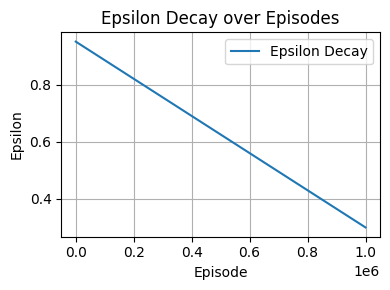

In [10]:
plot_epsilon_decay(epsilons, num_episodes)

In [43]:
def plot_rewards(average_reward):
    episodes_per_chunk = 1000
    num_chunks = len(average_reward)
    total_episodes = num_chunks * episodes_per_chunk

    plt.figure(figsize=(4, 3))
    plt.plot(np.arange(1, total_episodes + 1, episodes_per_chunk), average_reward, label='Average Reward')
    plt.title('Average Reward per 1000 Episode ')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

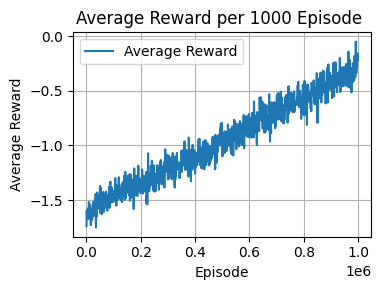

In [44]:
plot_rewards(average_rewards)

In [12]:
def evaluate(eval_agent, blackjack_env, num_episodes, rule_6_to_5, rule_no_dd_hard_11):
    total_rewards = 0
    wins = 0
    losses = 0
    draws = 0
    episode_rewards = []
    original_epsilon = eval_agent.epsilon
    eval_agent.epsilon = 0  # Set epsilon to 0 to ensure no exploration
    
    for episode in range(num_episodes):
        current_state = blackjack_env.reset()
        end_game = False
        episode_reward = 0

        while not end_game:
            current_action = eval_agent.select_action(current_state)
            next_state, reward, end_game = blackjack_env.step(current_action, rule_6_to_5, rule_no_dd_hard_11)
            current_state = next_state
            episode_reward += reward
        
        total_rewards += episode_reward
        episode_rewards.append(episode_reward)

        if episode_reward > 0:
            wins += 1
        elif episode_reward == 0:
            draws += 1
        else:
            losses += 1

    average_reward = total_rewards / num_episodes
    win_rate = wins / num_episodes
    loss_rate = losses / num_episodes
    draw_rate = draws / num_episodes

    print(f"Average reward: {average_reward}")
    print(f"Number of wins: {wins}, Win rate: {win_rate}")
    print(f"Number of losses: {losses}, Loss rate: {loss_rate}")
    print(f"Number of draws: {draws}, Draw rate: {draw_rate}")

    eval_agent.epsilon = original_epsilon

    return eval_agent, episode_rewards, average_reward, win_rate, loss_rate, draw_rate


In [16]:
number_of_episodes = 100000
eval_agent, episode_rewards, average_reward, win_rate, loss_rate, draw_rate = evaluate(trained_agent, blackjack_env, number_of_episodes,False,False)

Average reward: 0.43749
Number of wins: 44276, Win rate: 0.44276
Number of losses: 47848, Loss rate: 0.47848
Number of draws: 7876, Draw rate: 0.07876


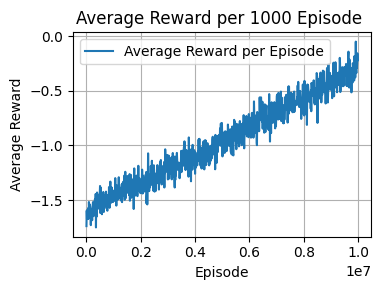

In [14]:
plot_rewards(average_rewards)

#### Rule Variations

In [36]:
test_blackjack_bs(100000,False,False)
print('-----------------------------------------------')
test_blackjack_bs(100000,True,True)

Average  win reward : 2.12 , average loss reward : -1.08 , average draw reward: 0.53
Wins: 43565 , win percentage: 43.56%
Losses: 46835 , loss percentage: 46.84%
Draws: 9600 , draw percentage: 9.60%
-----------------------------------------------
Average  win reward : 1.09 , average loss reward : -1.05 , average draw reward: 4.37
Wins: 38969 , win percentage: 38.97%
Losses: 46688 , loss percentage: 46.69%
Draws: 14343 , draw percentage: 14.34%


Name : Preeti Venkataraman Hegde

Matriculation Id : 5123764

Email : preetivenkataraman.hegde@study.thws.de